### Extract Frames from Video

In [2]:
# !mkdir data/frames
# !ffmpeg -i data/data_src.mp4 frames/video_frame_%05d.png

### Import Libraries

In [1]:
import os
import torch
import cv2
import json_tricks
import numpy as np
from tqdm import tqdm
from argparse import ArgumentParser
from face_alignment.detection.sfd import FaceDetector
from face_alignment import FaceAlignment, LandmarksType
from skimage.transform._geometric import _umeyama as umeyama
from lib.bisenet import BiSeNet
import matplotlib.pyplot as plt

### Arguments

In [2]:
CPU = False
SIZE = 256
MAX_DETECTION_SIZE = 1e10
JPG = False
MIN_SIZE = 0.01
MIN_CONFIDENCE = 0.9
EXPORT_PATH = 'data/face_images'
PATH = 'data/frames'

### Initialization

In [3]:
if not os.path.exists(EXPORT_PATH):
    os.mkdir(EXPORT_PATH)

In [4]:
device = 'cuda' if torch.cuda.is_available() and not CPU else 'cpu'
print(device)

cuda


In [5]:
face_detector = FaceDetector(device=device, verbose=False)
face_aligner = FaceAlignment(LandmarksType.TWO_D, device=device, verbose=False)

In [6]:
masker = BiSeNet(n_classes=19)
if device == 'cuda':
    masker.cuda()
model_path = 'models/BiSeNet.pth'
masker.load_state_dict(torch.load(model_path))
masker.eval()
desired_segments = [1, 2, 3, 4, 5, 6, 10, 12, 13]

In [7]:
alignment_data = {}

In [8]:
list_of_images_in_dir = [file for file in os.listdir(PATH) if os.path.isfile(os.path.join(PATH, file))]
print(f'Number of identified frames: {len(list_of_images_in_dir)}')

Number of identified frames: 1619


### Image Preparation

#### Understanding

In [9]:
file = list_of_images_in_dir[0]
filename, extension = os.path.splitext(file)
image_bgr = cv2.imread(os.path.join(PATH, file))
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
height, width, channels = image_rgb.shape
adjustment = MAX_DETECTION_SIZE / max(height, width)
if adjustment < 1.0:
    resized_image = cv2.resize(image_rgb, None, fx=adjustment, fy=adjustment)
else:
    resized_image = image_rgb
    adjustment = 1.0
faces = face_detector.detect_from_image(resized_image)

In [10]:
face = faces[0]
faces[0][4]

0.9999945163726807

620 65 786 303


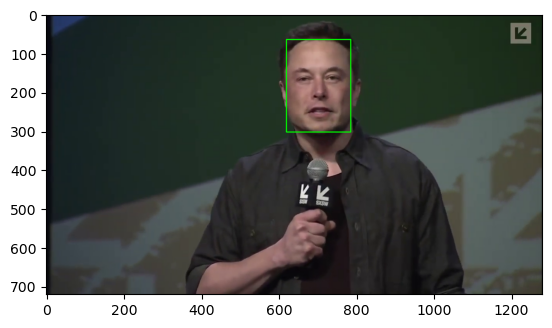

In [11]:
top_left_x, top_left_y, bottom_right_x, bottom_right_y = (face[:4] / adjustment).astype(int)
print(top_left_x, top_left_y, bottom_right_x, bottom_right_y)
cv2.rectangle(image_rgb, (int(top_left_x), int(top_left_y)), (int(bottom_right_x), int(bottom_right_y)), (0, 255, 0), 2)
plt.imshow(image_rgb)

In [12]:
landmarks = face_aligner.get_landmarks_from_image(image_rgb, detected_faces = [face[0:4]/adjustment])

In [13]:
landmark_image = image_rgb.copy()
landmark_image = cv2.rectangle(
    landmark_image, 
    (int(top_left_x), int(top_left_y)), (int(bottom_right_x), int(bottom_right_y)),
    thickness = 10,
    color=(0, 0, 0)
)

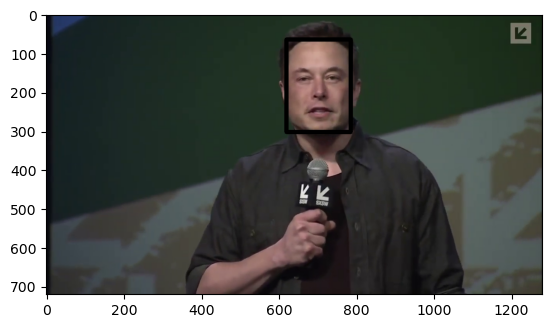

In [14]:
plt.imshow(landmark_image)

In [15]:
right_eye = np.mean(landmarks[0][36:42], axis=0)
left_eye = np.mean(landmarks[0][42:48], axis=0)
nose_tip = landmarks[0][30]
right_mouth = landmarks[0][48]
left_mouth = landmarks[0][54]

limited_landmarks = np.stack((
    right_eye,
    left_eye,
    nose_tip,
    right_mouth,
    left_mouth
))

In [16]:
limited_landmarks

array([[667.1667 , 167.     ],
       [740.3333 , 164.16667],
       [708.     , 203.     ],
       [675.     , 254.     ],
       [740.     , 251.     ]], dtype=float32)

In [17]:
colors = [[255, 0, 0],  # Blue
          [0, 255, 0],  # Green
          [0, 0, 255],  # Red
          [255, 255, 0],  # Cyan
          [0, 255, 255]]  # Yellow

In [18]:
for count, landmark in enumerate(limited_landmarks):
    landmark_adjusted = landmark.astype(int)
    landmark_image = cv2.circle(landmark_image, tuple(landmark_adjusted), radius=10, thickness=-1, color=colors[count])

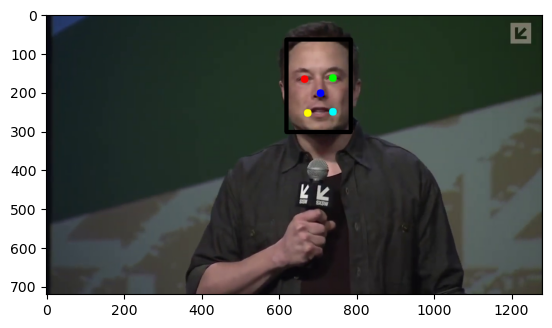

In [19]:
plt.imshow(landmark_image)

In [20]:
detected_face = image_bgr[top_left_y:bottom_right_y, top_left_x:bottom_right_x]

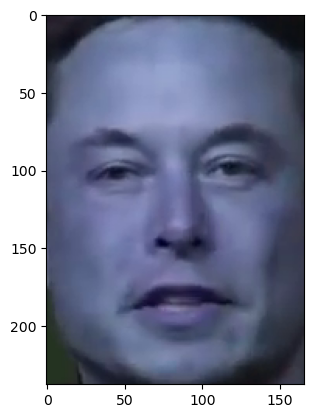

In [21]:
plt.imshow(detected_face)

In [22]:
MEAN_FACE = np.array([
  [0.25, 0.22],
  [0.75, 0.22],
  [0.50, 0.51],
  [0.26, 0.78],
  [0.74, 0.78]
])

In [23]:
warp_matrix = umeyama(
  limited_landmarks,
  MEAN_FACE * (SIZE * .3) + (SIZE * .35),
  True
)

In [24]:
warp_matrix

array([[ 5.11071952e-01, -2.19706182e-02, -2.28301666e+02],
       [ 2.19706182e-02,  5.11071952e-01,  6.42235439e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [25]:
aligned_face = image_bgr.copy()

In [26]:
aligned_face = cv2.warpAffine(aligned_face, warp_matrix[:2], (SIZE, SIZE))

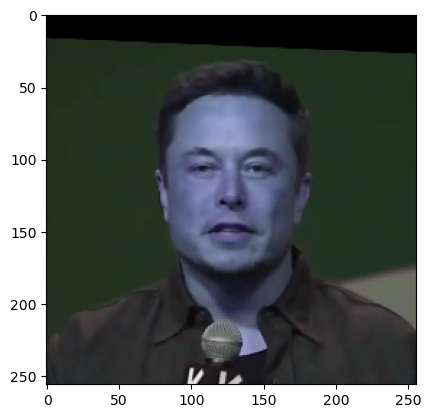

In [27]:
plt.imshow(aligned_face)

#### .

In [35]:
for file in tqdm(list_of_images_in_dir):
    file_name, extension = os.path.splitext(file)
    # if file_name != "video_frame_01584":
    #     continue
    image_bgr = cv2.imread(os.path.join(PATH, file))
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    height, width = image_rgb.shape[:2]
    # print(image_rgb.shape)
    adjustment = MAX_DETECTION_SIZE / max(height, width)
    # print(adjustment)
    if adjustment < 1.0:
        # print('here')
        resized_image = cv2.resize(image_rgb, None, fx=adjustment, fy=adjustment)
    else:
        resized_image = image_rgb
        adjustment = 1.0
    # print(adjustment)
    # print(resized_image.shape)
    #Face detection
    faces = face_detector.detect_from_image(resized_image)
    for idx, face in enumerate(faces):
        top_left_x, top_left_y, bottom_right_x, bottom_right_y = (face[0:4] / adjustment).astype(int)
        # print(top_left_x, top_left_y, bottom_right_x, bottom_right_y)
        top_left_x = max(0, top_left_x)
        top_left_y = max(0, top_left_y)
        bottom_right_x = min(width, bottom_right_x)
        bottom_right_y = min(height, bottom_right_y)
        # print(top_left_x, top_left_y, bottom_right_x, bottom_right_y)
        confidence = face[4]
        if confidence < MIN_CONFIDENCE:
            continue

        face_height = bottom_right_x - top_left_x
        face_width = bottom_right_y - top_left_y
        face_size = face_height * face_width
        
        if face_size/(height*width) < MIN_SIZE:
            print(file_name, face_size/(height*width), MIN_SIZE)
            continue
    
        detected_face = image_bgr[top_left_y:bottom_right_y, top_left_x:bottom_right_x]
        cv2.imwrite(os.path.join(EXPORT_PATH, f'face_bbox_{file_name}_{idx}.png'), detected_face)

        #Face Landmarking and Aligning
        landmarks = face_aligner.get_landmarks_from_image(
            image_rgb, detected_faces = [face[0:4]/adjustment]
        )

        landmark_image = image_bgr.copy()
        landmark_image = cv2.rectangle(
            landmark_image,
            (int(top_left_x), int(top_left_y)), (int(bottom_right_x), int(bottom_right_y)),
            thickness = 10,
            color = (0, 0, 0)
        )

        right_eye = np.mean(landmarks[0][36:42], axis=0)
        left_eye = np.mean(landmarks[0][42:48], axis=0)
        nose_tip = landmarks[0][30]
        right_mouth = landmarks[0][48]
        left_mouth = landmarks[0][54]
        
        limited_landmarks = np.stack((
            right_eye,
            left_eye,
            nose_tip,
            right_mouth,
            left_mouth
        ))

        colors = [[255, 0, 0],  # Blue
                      [0, 255, 0],  # Green
                      [0, 0, 255],  # Red
                      [255, 255, 0],  # Cyan
                      [0, 255, 255]]  # Yellow
        
        for count, landmark in enumerate(limited_landmarks):
            landmark_adjusted = landmark.astype(int)
            landmark_image = cv2.circle(
                landmark_image, 
                tuple(landmark_adjusted), 
                radius=10, 
                thickness=-1, 
                color=colors[count]
            )
        cv2.imwrite(os.path.join(EXPORT_PATH, f'face_landmarks_{file_name}_{idx}.png'), landmark_image)

        mean_face = np.array([[0.25, 0.22],
                                  [0.75, 0.22],
                                  [0.50, 0.51],
                                  [0.26, 0.78],
                                  [0.74, 0.78]])

        warp_matrix = umeyama(limited_landmarks,
                              mean_face * (SIZE * .3) + (SIZE * .35),
                              True)

        aligned_face = image_bgr.copy()

        aligned_face = cv2.warpAffine(aligned_face,
                                      warp_matrix[:2],
                                      (SIZE, SIZE))

        cv2.imwrite(os.path.join(EXPORT_PATH, f'face_aligned_{file_name}_{idx}.png'), aligned_face)

        if file not in alignment_data.keys():
            alignment_data[file] = {
                'faces': list()
            }
        alignment_data[file]['faces'].append({
            'landmark': landmarks, 'warp_matrix': warp_matrix
        })

        mask_face = cv2.resize(aligned_face, (512, 512))
        mask_face = torch.tensor(
            mask_face,
            device=device
        ).unsqueeze(0)
        mask_face = mask_face.permute(0, 3, 1, 2) / 255
        if device == 'cuda':
            mask_face.cuda()
        segments = masker(mask_face)[0]

        segments = torch.softmax(segments, dim=1)
        segments = torch.nn.functional.interpolate(
            segments, size=(256, 256),
            mode='bicubic',
            align_corners=False
        )
        mask = torch.where(torch.sum(segments[:, desired_segments, :, :], dim=1) > .7,
                               255,
                               0)[0]
        mask = mask.cpu().numpy()
        cv2.imwrite(os.path.join(EXPORT_PATH, f'face_mask_{file_name}_{idx}.png'), mask)

100%|███████████████████████████████████████| 1619/1619 [02:22<00:00, 11.36it/s]


In [38]:
with open(os.path.join(EXPORT_PATH, "face_alignments.json"), "w") as alignment_file:
    alignment_file.write(json_tricks.dumps(alignment_data, indent=4))